In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import pylab
from numpy.linalg import inv
%matplotlib qt

In [2]:
# Get calibration matrix
def get_cal():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    cal_images = glob.glob('camera_cal/calibration*.jpg')
    #cv2.startWindowThread()

    #images = os.listdir("camera_cal/")

    # Step through the list and search for chessboard corners
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #plt.imshow(img)
            #cv2.waitKey(500)

    # Returns calibration matrix and distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    #cv2.destroyAllWindows()
    
    return ret, mtx, dist, rvecs, tvecs

In [3]:
# This function applies distortion correction to a raw image
def undistort(img, mtx, dist):
#     # referenced code
#     h,  w = img.shape[:2]
#     newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),0,(w,h))
#     # referenced code
#     # source: https://blog.csdn.net/u010128736/article/details/52875137
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    rgb_undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
    return rgb_undist

In [16]:
'''
# This function creates a thresholded binary image using color transforms and gradients
def binary_img(undist, s_thresh=(130, 255), sx_thresh=(20, 120), r_thresh=90):
    undist = np.copy(undist)
    #dir_thresh=(0.524, 1.134)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian blur to get rid of noise
    blur = cv2.blur(gray,(13,13))
    l_blur = cv2.blur(l_channel, (5,5))
    
    # Use the red channel as well
    r_channel = undist[:,:,0]
    
    # sobel x for L channel
    sobelx_l = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=3) # Take the derivative in x
    abs_sobelx_l = np.absolute(sobelx_l) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_l = np.uint8(255*abs_sobelx_l/np.max(abs_sobelx_l))
    
    # Sobel x
    sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=15) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel_l)
    sxbinary[(scaled_sobel_l >= sx_thresh[0]) & (scaled_sobel_l <= sx_thresh[1])] = 1
    
    # Sobel y and direction of gradient
    sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=15) # Take the derivative in y
    abs_sobely = np.absolute(sobely)
    angle = np.arctan2(np.absolute(abs_sobely), np.absolute(abs_sobelx))
    angle_binary = np.zeros_like(angle)
    #angle_binary[(angle >= dir_thresh[0]) & (angle <= dir_thresh[1])] = 1
    
    # Threshold s channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold r channel
    r_binary = np.zeros_like(r_channel)
    r_binary[r_channel >= r_thresh] = 1
    
    # Stack each channel
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) & (r_binary == 1)] = 1
    return combined_binary

In [200]:
''' Reference: 
    HSV yellow threshold: https://github.com/ChengZhongShen/Advanced_Lane_Lines/blob/master/helper/image_process.py 
    RGB white threshold: https://medium.com/@tjosh.owoyemi/finding-lane-lines-with-colour-thresholds-beb542e0d839'''

# This function creates a thresholded binary image using color transforms and gradients
def binary_img(undist, s_thresh=(200, 255), sx_thresh=(30, 120), y_low=(10, 50, 0), y_high=(40, 255, 255), \
              w_low=(100,100,200), w_high=(255,255,255)):
    undist = np.copy(undist)
    
    dark = False
    #dir_thresh=(0.524, 1.134)
    
    # To be used for gradient thresholding when image is dark
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    sx_gray = (20, 120)
    
    hsv = cv2.cvtColor(undist, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    height = undist.shape[0]
    width = undist.shape[1]
    bright_l = int(np.mean(v_channel[height//2:, :width//2])) # use left bottom corner brightness as ref
    bright_r = int(np.mean(v_channel[height//2:, width//2:])) # use right bottom corner brightness as ref
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # sobel x for L channel
    sobelx_l = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=5) # Take the derivative in x
    abs_sobelx_l = np.absolute(sobelx_l) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_l = np.uint8(255*abs_sobelx_l/np.max(abs_sobelx_l))
    
    # Threshold s channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Losen the thresholds if the image is darker
    '''
    if bright_l < 70:
        y_low = (0,0,0)
        y_high = (50, 255, 255)
        dark = True'''
    '''
    if (bright_r < 70) or (bright_l < 70):
        s_thresh = (140, 255)
        sx_thresh = (15, 120)
        dark = True
    '''
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel_l)
    sxbinary[(scaled_sobel_l >= sx_thresh[0]) & (scaled_sobel_l <= sx_thresh[1])] = 1
    
    # Threshold for yellow color
    y_img = cv2.inRange(hsv, y_low, y_high)
    y_binary = np.copy(y_img)
    y_binary[y_img > 1] = 1
    
    # Threshold for white color
    w_img = cv2.inRange(undist, w_low, w_high)
    w_binary = np.copy(w_img)
    w_binary[w_img > 1] = 1
    
    # Binary image to be used for the right lane
    r_binary = np.zeros_like(sxbinary)
    r_binary[(s_binary == 1) | (sxbinary == 1) | (w_binary == 1)] = 1
    '''
    # Don't use yellow color detection if image is dark
    if bright_l < 70:
        # sobel x for gray image
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        
        sxbinary_gray = np.zeros_like(scaled_sobel)
        sxbinary_gray[(scaled_sobel_l >= sx_thresh[0]) & (scaled_sobel_l <= sx_thresh[1])] = 1
        
        dark_binary = np.zeros_like(sxbinary)
        dark_binary[(s_binary == 1) | (sxbinary_gray == 1) | (w_binary == 1)] = 1
        
        return dark_binary, dark
    '''
    # combine the two binary, right and left
    r_binary[:,:640] = 0 # use right side of r_binary
    y_binary[:,640:] = 0 # use left side of y_binary
    
    # Stack each channel
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(y_binary == 1) | (r_binary == 1)] = 1
    return combined_binary, dark

In [175]:
# This function applies perspective transform to the binary image
def transform(binary):
    # Define source and destination points
    src = np.float32([[567, 470], [713, 470], [1035, 675], [270, 675]])
    dst = np.float32([[200, 0], [1000, 0], [1000, 720], [200, 720]])
    
    img_size = (binary.shape[1], binary.shape[0])
    
    # Get perspective matrix and warp the image
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)
    return M, warped

In [230]:
# Detect lane pixels in the first frame
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Do not consider the central region to improve detection accuracy
    histogram[400:900] = 0
    
    #print(histogram[140])
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    lane_center = np.int((leftx_base + rightx_base)/2)

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 7
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [194]:
# Fit the lane pixels in the the frames where moving window approach is applied
def fit_polynomial(binary_warped, left_fit_prev, right_fit_prev):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    # use polynomial from the previous frame if not enough pixels pass the threshold
    if len(leftx) < 10000:
        left_fit = left_fit_prev
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) < 3000:
        right_fit = right_fit_prev
    else:
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    left_fit_old = left_fit
    right_fit_old = right_fit

    return out_img, left_fit, right_fit, ploty, left_fit_old, right_fit_old

In [234]:
# Initiate the fit coefficients
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

# Detect lane pixels and fit to find the lane boundary in the following frames
def fit_poly(img_shape, leftx, lefty, rightx, righty, left_fit_prev, right_fit_prev):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    if len(leftx) < 10000:
        left_fit = left_fit_prev
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) < 3000:
        right_fit = right_fit_prev
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_fit, right_fit, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 30

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, left_fit_new, right_fit_new, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty, \
                                                                        left_fit, right_fit)
    
    return left_fit_new, right_fit_new

In [10]:
# Determine the curvature of the lane
def measure_curvature_real(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/706 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

In [11]:
# Determine the vehicle position with respect to center
# Assuming the camera is at the center of the vehicle's front
def find_offset(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    lane_center = np.int((leftx_base + rightx_base)/2)
    
    # Find offset
    offset = (midpoint - lane_center) * 3.7 / 706
    return offset

In [12]:
# Warp the detected lane boundaries back onto the original image and fill in the lane with green

def fill_lane(binary_warped, undist, Minv, ploty, left_fitx, right_fitx):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #rgb_result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    return result

In [13]:
# Calibration
ret, mtx, dist, rvecs, tvecs = get_cal()

In [80]:
# Make a list of raw images and create binary images
raw_images = glob.glob('test_images/test*.jpg')

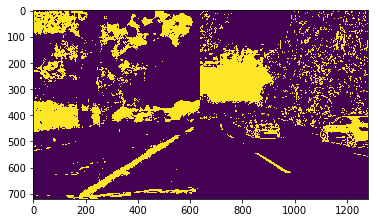

In [158]:
img = cv2.imread(raw_images[5])
undist = undistort(img, mtx, dist)
binary, dark = binary_img(undist)
plt.imshow(binary)

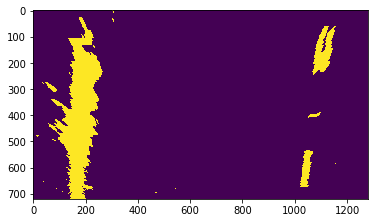

In [159]:
M, warped = transform(binary)
plt.imshow(warped)

5831.46769401
6142.43323883


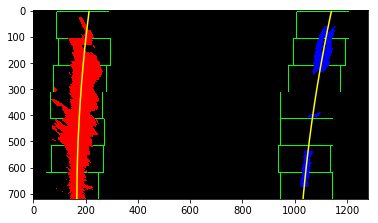

In [160]:
out_img, left_fit, right_fit, ploty = fit_polynomial(warped)
plt.imshow(out_img)
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)
print(left_curverad)
print(right_curverad)

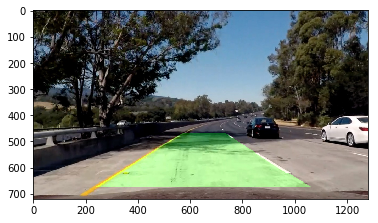

In [161]:
Minv = inv(M)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
result = fill_lane(warped, undist, Minv, ploty, left_fitx, right_fitx)
plt.imshow(result)

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [238]:
# Keep track of number of frames
frame = 1

# Initialize variables that store polynomials
left_fit_old = None
right_fit_old = None
left_fit_prev = None
right_fit_prev = None
ploty = None
debug_window = None

# Use just one function to process images
def process_image(raw_image):
    global frame, left_fit_old, right_fit_old, left_fit_prev, right_fit_prev, ploty, debug_window
    
    # Create warped binary image
    undist = cv2.undistort(raw_image, mtx, dist, None, mtx)
    binary, dark = binary_img(undist)
    M, warped = transform(binary)

    # Calculating the radius of curvature
    # lane_img, left_fit, right_fit, ploty = fit_polynomial(warped)
    
    # do the moving window thing every centain number of frames
    remainder = frame % 5
    
    if (frame == 1 or remainder == 0):
        lane_img, left_fit, right_fit, ploty, left_fit_old, right_fit_old = fit_polynomial(warped, left_fit_prev, right_fit_prev)
        left_fit_prev = left_fit_old
        right_fit_prev = right_fit_old
        debug_window = cv2.resize(lane_img, (640, 360))
    else:
        left_fit, right_fit = search_around_poly(warped, left_fit_old, right_fit_old)
        left_fit_old = left_fit
        right_fit_old = right_fit
    '''
    lane_img, left_fit, right_fit, ploty, left_fit_old, right_fit_old = fit_polynomial(warped, left_fit_prev, right_fit_prev)
    left_fit_prev = left_fit_old
    right_fit_prev = right_fit_old
    debug_window = cv2.resize(lane_img, (640, 360))
    '''
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)

    # Fill the space between the lanes
    Minv = inv(M)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    result = fill_lane(warped, undist, Minv, ploty, left_fitx, right_fitx)

    # Writing the radius and offset to the video
    rad = int((left_curverad + right_curverad)/2)
    offset = find_offset(warped)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text1 = "Radius of Curvature = " + str(rad) +"(m)"
    text2 = "Vehicle is {0:.2f}m right of center".format(offset)
    cv2.putText(result, text1, (50,50), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result, text2, (50,100), font, 1.5, (255,255,255), 2, cv2.LINE_AA)

    # Update the number of frames
    frame += 1

    result[:360,640:]=debug_window

    return result

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [02:00<00:00,  4.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 15s, sys: 5.69 s, total: 1min 20s
Wall time: 2min 3s


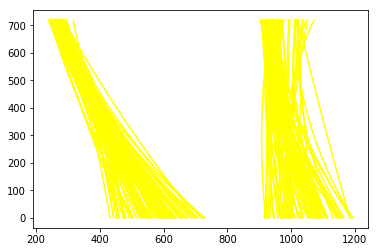

In [239]:
#white_output = 'challenge_video_output_10s.mp4'
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0, 10)
white_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [240]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))